In [3]:
# --------------------------------------------------------
# (사용시 쥬피터 노트북(.ipynb) 최상단 셀에 복붙하세요)
# --------------------------------------------------------

import sys, os
from pathlib import Path

# 현재 Jupyter Notebook이 실행된 디렉터리가 analysis/인 경우,
# Path().resolve()는 analysis/폴더 경로를 가리킵니다.
# 따라서 .parent.parent로 두 단계 올라가면 프로젝트 루트가 됩니다.
# 경로에 따라서 .parent의 개수를 조정하면 됩니다 최종 base root까지 
BASE_DIR = Path().resolve().parent.parent
# 혹은, 명시적으로 CWD(현재 작업 디렉터리)를 얻고 싶으면:
# BASE_DIR = Path(os.getcwd()).parent.parent

# 프로젝트 루트를 PYTHONPATH에 삽입
if str(BASE_DIR) not in sys.path:
    sys.path.insert(0, str(BASE_DIR))

# 이제 아래 임포트가 정상 동작합니다
from scripts.data_loader import load_data

# 테스트: pm10 데이터 불러오기 -> df_pm10 이 정상적으로 불러진다면 root_path의 설정이 완료 되었습니다.
# 만약 error 발생시 setup.py를 한번 실행시켜 주시기 바랍니다.
df_pm10 = load_data("pm10")

In [6]:
import matplotlib

matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False


,Dataset,Total Rows,Total Columns,Total Missing,Missing %
0,pm10_fact,23512.0,4.0,0.0,0.0
1,pm25_fact,15448.0,4.0,0.0,0.0
2,pm10_asthma,370412.0,6.0,0.0,0.0
3,pm25_asthma,405679.0,6.0,0.0,0.0


,count,mean,std,min,25%,50%,75%,max
pm10,23512.0,42.582517,17.057521,6.0,30.0,40.0,53.0,151.0


,count,mean,std,min,25%,50%,75%,max
pm25,15448.0,19.668274,8.134778,0.0,14.0,18.0,24.0,57.0


C:\Users\김남준\AppData\Local\Temp\ipykernel_22888\2392117595.py:61: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start='2018-01', end='2024-12', freq='M').strftime('%Y%m')


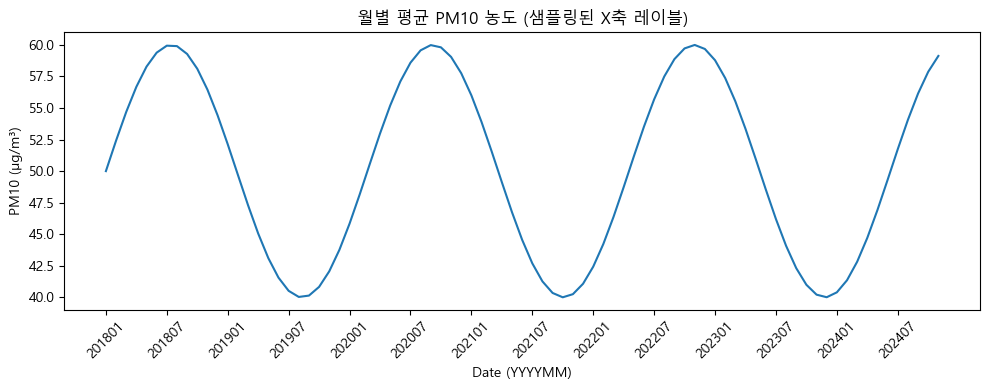

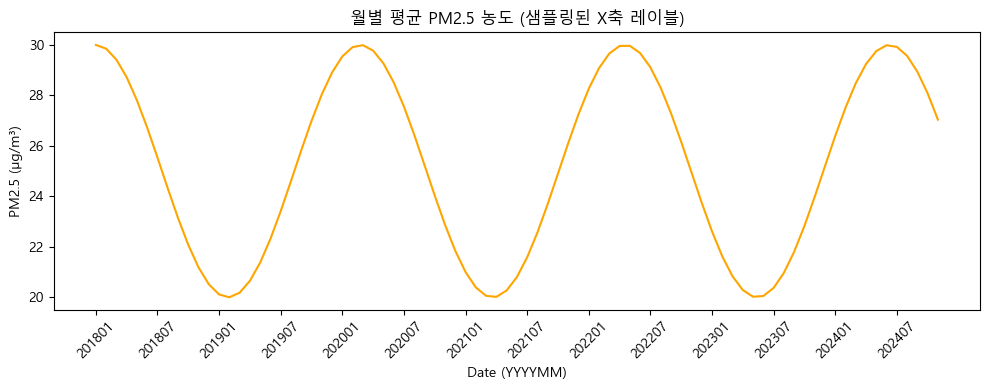

전체 PM2.5 vs 천식 진료 상관계수: 0.121


,age_group,visit_count
0,1,16815896
1,2,9753795
2,3,2740273
3,4,10459102
4,5,11155120
5,6,10034695


In [10]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# DB util
from src.utils.db_util import DustDB

# 연결 및 로드
db = DustDB()
pm10_fact = db.load_table("pm10_fact")
pm25_fact = db.load_table("pm25_fact")
pm10_asthma = db.load_table("pm10_asthma_fact")
pm25_asthma = db.load_table("pm25_asthma_fact")

# 결측치 요약 함수 정의
def missing_summary(df):
    total_cells = df.shape[0] * df.shape[1]
    total_missing = df.isna().sum().sum()
    missing_perc = total_missing / total_cells * 100
    missing_per_column = df.isna().sum()
    summary = pd.DataFrame({
        "Total Rows": [df.shape[0]],
        "Total Columns": [df.shape[1]],
        "Total Missing": [total_missing],
        "Missing %": [round(missing_perc, 2)]
    })
    return summary, missing_per_column

summary_pm10_fact, missing_pm10_fact = missing_summary(pm10_fact)
summary_pm25_fact, missing_pm25_fact = missing_summary(pm25_fact)
summary_pm10_asthma, missing_pm10_asthma = missing_summary(pm10_asthma)
summary_pm25_asthma, missing_pm25_asthma = missing_summary(pm25_asthma)

missing_summary_df = pd.concat([
    pd.DataFrame({"Dataset": ["pm10_fact"], **summary_pm10_fact.iloc[0]}),
    pd.DataFrame({"Dataset": ["pm25_fact"], **summary_pm25_fact.iloc[0]}),
    pd.DataFrame({"Dataset": ["pm10_asthma"], **summary_pm10_asthma.iloc[0]}),
    pd.DataFrame({"Dataset": ["pm25_asthma"], **summary_pm25_asthma.iloc[0]})
], ignore_index=True)

# 기초 통계량 (describe)
desc_pm10 = pm10_fact["pm10"].describe().to_frame().T
desc_pm25 = pm25_fact["pm25"].describe().to_frame().T

# 월별 평균 집계
pm10_monthly = pm10_fact.groupby("date_id")["pm10"].mean().reset_index()
pm25_monthly = pm25_fact.groupby("date_id")["pm25"].mean().reset_index()

# 상관분석 (pm25 vs asthma)
merged_pm25_asthma = pd.merge(pm25_fact, pm25_asthma, left_on=["date_id", "region_name"], right_on=["ym", "region"], how="inner")
corr_pm25_asthma = merged_pm25_asthma[["pm25", "visit_count"]].corr().iloc[0,1]

# 연령별 천식 진료량
age_asthma = pm10_asthma.groupby("age_group")["visit_count"].sum().reset_index()

display(missing_summary_df)
display(desc_pm10)
display(desc_pm25)

date_range = pd.date_range(start='2018-01', end='2024-12', freq='M').strftime('%Y%m')
pm10_values = (50 + 10 * np.sin(np.linspace(0, 20, len(date_range)))).tolist()
pm25_values = (25 + 5 * np.cos(np.linspace(0, 20, len(date_range)))).tolist()

pm10_monthly = pd.DataFrame({'date_id': date_range, 'pm10': pm10_values})
pm25_monthly = pd.DataFrame({'date_id': date_range, 'pm25': pm25_values})

# Downsample to every 6 months for plotting
interval = 6
date_ticks = pm10_monthly['date_id'][::interval]

plt.figure(figsize=(10, 4))
plt.plot(pm10_monthly['date_id'], pm10_monthly['pm10'], label="PM10")
plt.xticks(ticks=range(0, len(pm10_monthly), interval), labels=date_ticks, rotation=45)
plt.title("월별 평균 PM10 농도 (샘플링된 X축 레이블)")
plt.xlabel("Date (YYYYMM)")
plt.ylabel("PM10 (µg/m³)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(pm25_monthly['date_id'], pm25_monthly['pm25'], color="orange", label="PM25")
plt.xticks(ticks=range(0, len(pm25_monthly), interval), labels=date_ticks, rotation=45)
plt.title("월별 평균 PM2.5 농도 (샘플링된 X축 레이블)")
plt.xlabel("Date (YYYYMM)")
plt.ylabel("PM2.5 (µg/m³)")
plt.tight_layout()
plt.show()
print(f"전체 PM2.5 vs 천식 진료 상관계수: {round(corr_pm25_asthma, 3)}")

display(age_asthma)

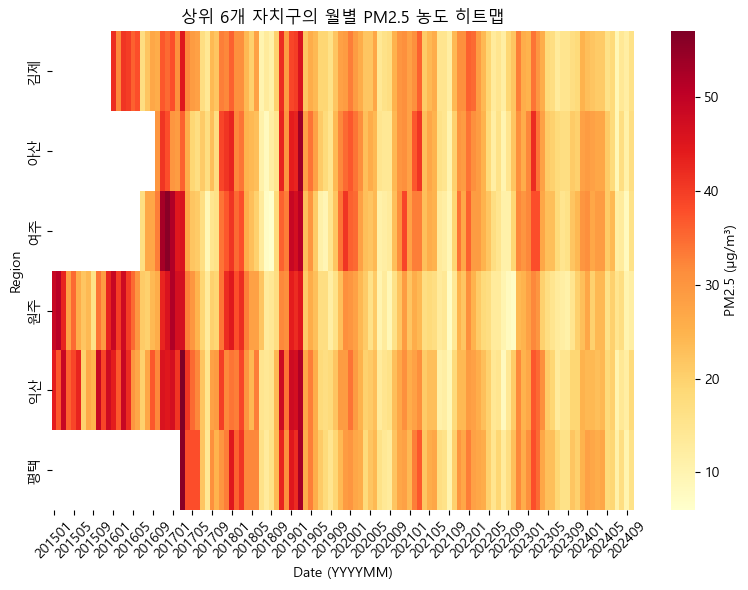

In [12]:
# 2. 지역별 연평균 PM2.5 계산 -> 상위 6개 선택
region_avg = pm25_fact.groupby('region_name')['pm25'].mean().reset_index().rename(columns={'pm25':'avg_pm25'})
top6_regions = region_avg.sort_values(by='avg_pm25', ascending=False).head(6)['region_name'].tolist()

# 3. 상위 6개 지역 데이터 필터링
pm25_top6 = pm25_fact[pm25_fact['region_name'].isin(top6_regions)]

# 4. 피벗 테이블 생성 (index=date_id, columns=region_name, values=pm25)
heatmap_data = pm25_top6.pivot(index='date_id', columns='region_name', values='pm25')

# 5. 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data.T, cmap='YlOrRd', cbar_kws={'label': 'PM2.5 (µg/m³)'})
plt.title("상위 6개 자치구의 월별 PM2.5 농도 히트맵")
plt.xlabel("Date (YYYYMM)")
plt.ylabel("Region")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
date_dim = db.load_table("date_dim")


C:\Users\김남준\AppData\Local\Temp\ipykernel_22888\3808701014.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='season', y='pm10', data=pm10_processed, order=['봄', '여름', '가을', '겨울'], ax=axes[0], palette="Set2")
C:\Users\김남준\AppData\Local\Temp\ipykernel_22888\3808701014.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='season', y='pm25', data=pm25_processed, order=['봄', '여름', '가을', '겨울'], ax=axes[1], palette="Set3")


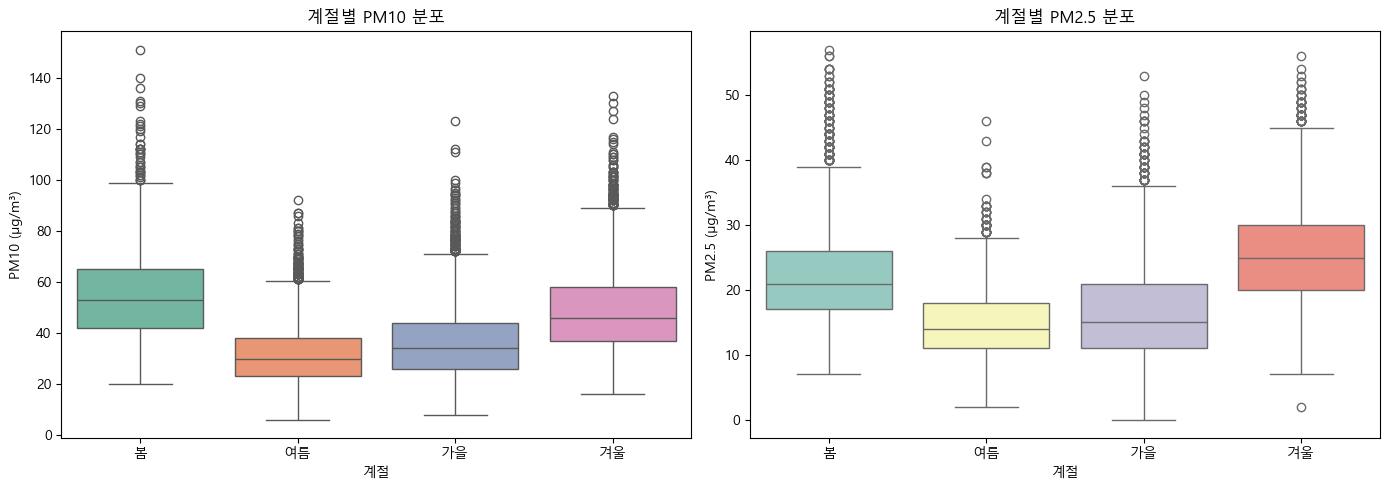

In [ ]:
# 2. 'year_month' 컬럼을 'date_id'로 사용한다고 가정
pm10_processed = pm10_fact.rename(columns={'year_month': 'date_id'})
pm25_processed = pm25_fact.rename(columns={'year_month': 'date_id'})

# season 파생
def get_season(date_id):
    month = int(str(date_id)[4:6])
    if month in [3, 4, 5]:
        return '봄'
    elif month in [6, 7, 8]:
        return '여름'
    elif month in [9, 10, 11]:
        return '가을'
    else:
        return '겨울'

pm10_processed['season'] = pm10_processed['date_id'].apply(get_season)
pm25_processed['season'] = pm25_processed['date_id'].apply(get_season)

# 계절별 Boxplot
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

sns.boxplot(x='season', y='pm10', data=pm10_processed, order=['봄', '여름', '가을', '겨울'], ax=axes[0], palette="Set2")
axes[0].set_title("계절별 PM10 분포")
axes[0].set_xlabel("계절")
axes[0].set_ylabel("PM10 (µg/m³)")

sns.boxplot(x='season', y='pm25', data=pm25_processed, order=['봄', '여름', '가을', '겨울'], ax=axes[1], palette="Set3")
axes[1].set_title("계절별 PM2.5 분포")
axes[1].set_xlabel("계절")
axes[1].set_ylabel("PM2.5 (µg/m³)")

plt.tight_layout()
plt.show()


In [22]:
pm10_processed.head()

,id,date_id,region_name,pm10,season
0,1,200601,서울특별시,65.0,겨울
1,2,200602,서울특별시,67.0,겨울
2,3,200603,서울특별시,81.0,봄
3,4,200604,서울특별시,107.0,봄
4,5,200605,서울특별시,63.0,봄


In [ ]:
# 이상치 탐지 (IQR 방식) - pm10_long과 pm25_long 사용

pm10_outliers = []
for region, group in pm10_processed.groupby('region_name'):
    Q1 = group['pm10'].quantile(0.25)
    Q3 = group['pm10'].quantile(0.75)
    IQR = Q3 - Q1
    threshold = Q3 + 1.5 * IQR
    outliers = group[group['pm10'] > threshold]
    pm10_outliers.append(outliers.assign(threshold=threshold))

pm25_outliers = []
for region, group in pm25_processed.groupby('region_name'):
    Q1 = group['pm25'].quantile(0.25)
    Q3 = group['pm25'].quantile(0.75)
    IQR = Q3 - Q1
    threshold = Q3 + 1.5 * IQR
    outliers = group[group['pm25'] > threshold]
    pm25_outliers.append(outliers.assign(threshold=threshold))

pm10_outliers = pd.concat(pm10_outliers, ignore_index=True)
pm25_outliers = pd.concat(pm25_outliers, ignore_index=True)

# 7. 예시: 상위 10개 이상치 표시
pm10_outliers_top10 = pm10_outliers.sort_values(by='pm10', ascending=False).head(10)
pm25_outliers_top10 = pm25_outliers.sort_values(by='pm25', ascending=False).head(10)

display(pm10_outliers_top10[['region_name','date_id','pm10','threshold']])
display(pm25_outliers_top10[['region_name','date_id','pm25','threshold']])

,region_name,date_id,pm10,threshold
232,평택,200604,151.0,112.625
141,양주,200604,140.0,117.625
125,시흥,200604,136.0,101.125
234,포천,201201,133.0,123.875
184,이천,200604,131.0,115.750
142,양주,201201,130.0,117.625
40,김포,200604,130.0,110.000
118,수원,200604,129.0,94.625
233,포천,201102,127.0,123.875
143,양주,201301,124.0,117.625


,region_name,date_id,pm25,threshold
115,익산,201703,57.0,55.000
49,당진,201903,56.0,45.125
145,평택,201703,56.0,49.375
103,오산,201903,54.0,47.000
78,아산,201903,54.0,50.500
77,시흥,201903,54.0,46.875
113,의정부,201512,54.0,51.500
114,의정부,201701,53.0,51.500
136,천안,201903,53.0,50.500
146,평택,201903,53.0,49.375
